In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error


class Preparer(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    #
    def fit(self, df):
        return self
    #
    def transform(self, df):
        # Drop rows with containing missing data
        # and reset index after drop
        df = df.dropna().reset_index(drop=True)
        
        # Remove indexing column (it does not contribute to 'y')
        if 'Unnamed: 0' in list(df):
            df = df.drop( "Unnamed: 0", axis=1 )
            # df.head()
        #
        
        return df
        # return super().fit_transform(X, y, **fit_params)
    #
#

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
#
num_pipeline = Pipeline(
    [
        ( 'prep',    Preparer() ), # Here it will take care of NaN/missing cells
        ( 'scaler',  MinMaxScaler() ),
        # it will return a np.array
    ]
)
#

# For the model:
def getFeatLabels(arr):
    # X     = dframe.drop("y", axis=1)
    # y     = dframe["y"].copy()
    X = arr[:, :-1]
    y = arr[:, -1]
    return X, y
#

def getModel(modelName):
    if modelName == "linear":
        return LinearRegression()
    elif modelName == "randomForest":
        return RandomForestRegressor()
    #
#

def pipe_RMSE_model(model, modelName, X, y, listColumns=None):
    rows = 200
    if listColumns == None:
        listColumns = [i for i in range( X.shape[1] )]
    #
    
    # Training on all the rows, considering only the columns in `listColumns`
    model.fit( X[:, listColumns], y )
    
    # visualizing the coefficients
    if modelName == "linear":
        plt.plot(model.coef_, ".")
        plt.xlabel("i-th coeff")
        plt.ylabel("coeff value")
    #
    
    # Preparing a small "test set" from training set:
    _X = X[:rows, listColumns]
    _y = y[:rows]
    
    # Prediction on the small "test set":
    y_pred = model.predict( _X )
    
    # display
    print( "RMSE for " + modelName + ":\n ", getRMSE( _y, y_pred ) )
    
    return model
#

def plot_actual_vs_prediction(labels, y_pred):
    plt.plot( labels, y_pred, ".", alpha=0.4)
    plt.xlim( (0, 1) )
    plt.ylim( (0, 1) )
    plt.plot( [0, 0.5, 1], [0, 0.5, 1], 'k-' )
    plt.xlabel("actual values")
    plt.ylabel("prediction")
    plt.show()
#


#
def getRMSE(y_test, y_prediction):
    final_mse  = mean_squared_error( y_test, y_prediction )
    final_rmse = np.sqrt(final_mse)
    return final_rmse
#

def validation( df_test, trainedModel, listColumns=None, poly=None ):
    # Work on the test set
    
    Xy_test_tr = num_pipeline.fit_transform( df_test )

    X_test_tr, y_test_tr = getFeatLabels( Xy_test_tr )

    if listColumns != None:
        X_test_tr = X_test_tr[ :, listColumns ]

        if poly != None: # it must be here, in a reduced number of columns!!
            X_test_tr = poly.fit_transform( X_test_tr )
        #
    #

    # Evaluation on the transformed test set:
    y_pred = trainedModel.predict( X_test_tr )

    print( "RMSE: ", getRMSE(y_test_tr, y_pred) )

    plot_actual_vs_prediction(y_test_tr, y_pred)
#



In [2]:
# load data
df = pd.read_csv("assignment.csv")
df.head()


,Unnamed: 0,par_0,par_1,par_2,par_3,par_4,par_5,par_6,par_7,par_8,...,par_15,par_16,par_17,par_18,par_19,par_20,par_21,par_22,par_23,y
0,0,1.544825,-2.651449,4.9,7.122420,1.320149,-6.226010,13.269417,12.997912,1.079452,...,32.567205,1.462498,-4.843070,1.409031,12.729955,1.755549,-0.537891,7.416177,7.945811,-3.254937
1,1,1.489066,-6.388961,12.9,2.725215,1.750599,-1.078572,1.574682,3.847310,1.843263,...,10.213950,1.669508,-5.483765,2.626350,16.638900,1.528123,-6.018913,1.759954,27.208328,2.354208
2,2,1.916499,-3.889092,10.3,9.877944,1.801302,-9.390142,-15.210752,14.457175,1.730271,...,7.231757,1.948760,-0.232627,1.655053,13.559015,1.016741,-1.222819,18.011166,23.372108,-4.403109
3,3,1.445916,-7.557142,-9.0,5.587049,1.205418,-3.508260,5.016086,4.808192,1.389905,...,12.537347,1.479762,-0.305782,1.807269,14.273751,1.773293,-3.460726,4.911595,7.252491,1.158646
4,4,1.727903,-0.335196,-6.9,5.001143,1.451378,-2.122920,7.380049,0.763368,1.919107,...,13.610878,1.671736,-3.434668,-11.584783,15.624194,1.532400,-2.535279,8.799152,-4.606025,-7.767470


In [3]:
# Split data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.head()


,Unnamed: 0,par_0,par_1,par_2,par_3,par_4,par_5,par_6,par_7,par_8,...,par_15,par_16,par_17,par_18,par_19,par_20,par_21,par_22,par_23,y
9254,9254,1.742785,-6.610018,3.6,13.771537,1.425519,-2.752433,1.572986,9.411560,1.954125,...,4.777667,1.218535,-5.041065,3.247007,-12.151267,1.876981,-4.831796,4.180515,10.103530,10.991465
1561,1561,1.987421,-3.263129,1.1,33.966304,1.052976,-4.677398,-24.930240,14.509863,1.280745,...,9.068134,1.443493,-2.578169,-12.445457,17.412869,1.729008,-4.680771,5.323091,8.604855,-0.653825
1670,1670,1.136302,-2.853046,4.5,8.306811,1.027677,-4.912526,17.635362,23.185669,1.202359,...,4.049058,1.343462,-7.833910,-2.151672,3.564132,1.446217,-5.598485,-2.384827,6.886503,-2.213211
6087,6087,1.194690,-6.856922,12.8,18.664825,1.436470,0.191838,4.235450,30.150840,1.539568,...,22.128753,1.664552,-3.214508,18.665638,6.754161,1.270716,0.560711,-5.627430,10.640952,0.510658
6669,6669,1.039279,-2.633360,-4.0,3.990691,1.948365,2.452614,2.544972,21.787204,1.968422,...,12.648554,1.012171,-0.996758,8.404741,22.974276,1.109349,-8.977159,14.331058,9.032082,-6.581167


In [4]:
#%%
# correlation matrix
corr_matrix = df_train.corr()
corr_matrix['y'].sort_values(ascending=False)

y             1.000000
par_8         0.123928
par_16        0.097319
par_20        0.064621
par_11        0.028744
par_3         0.025628
par_21        0.011137
par_6         0.007365
par_13        0.006695
par_17        0.006594
par_9         0.001652
par_7         0.001557
par_14        0.000956
par_5         0.000397
par_2        -0.000514
par_10       -0.003321
par_19       -0.004013
par_22       -0.006473
par_15       -0.008795
par_23       -0.009248
Unnamed: 0   -0.010525
par_1        -0.011691
par_18       -0.013974
par_0        -0.067799
par_12       -0.211779
par_4        -0.323982
Name: y, dtype: float64

In [5]:
#%%
# sorting by absolute value
corr_matrix = abs( df_train.corr() )
corr_matrix['y'].sort_values(ascending=False)

y             1.000000
par_4         0.323982
par_12        0.211779
par_8         0.123928
par_16        0.097319
par_0         0.067799
par_20        0.064621
par_11        0.028744
par_3         0.025628
par_18        0.013974
par_1         0.011691
par_21        0.011137
Unnamed: 0    0.010525
par_23        0.009248
par_15        0.008795
par_6         0.007365
par_13        0.006695
par_17        0.006594
par_22        0.006473
par_19        0.004013
par_10        0.003321
par_9         0.001652
par_7         0.001557
par_14        0.000956
par_2         0.000514
par_5         0.000397
Name: y, dtype: float64

In [6]:
#%%
corr =  abs( df_train.corr() )
corr.style.background_gradient(cmap='jet', vmax=0.32).set_precision(2)
# parameters are independents between them


/var/folders/6t/t_rvb9gx4xx_w8cfr0sgkn240000gn/T/ipykernel_80583/1357649850.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='jet', vmax=0.32).set_precision(2)


,Unnamed: 0,par_0,par_1,par_2,par_3,par_4,par_5,par_6,par_7,par_8,par_9,par_10,par_11,par_12,par_13,par_14,par_15,par_16,par_17,par_18,par_19,par_20,par_21,par_22,par_23,y
Unnamed: 0,1.00,0.02,0.02,0.02,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.00,0.02,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.01,0.01,0.01
par_0,0.02,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.07
par_1,0.02,0.01,1.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.03,0.00,0.01,0.01,0.02,0.00,0.00,0.02,0.01,0.02,0.01,0.01
par_2,0.02,0.00,0.00,1.00,0.01,0.01,0.01,0.01,0.02,0.00,0.00,0.02,0.00,0.02,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.01,0.01,0.01,0.00,0.00
par_3,0.00,0.00,0.02,0.01,1.00,0.00,0.01,0.02,0.02,0.00,0.01,0.01,0.00,0.02,0.02,0.00,0.00,0.01,0.01,0.00,0.02,0.02,0.01,0.00,0.01,0.03
par_4,0.01,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.00,0.02,0.01,0.00,0.32
par_5,0.00,0.00,0.00,0.01,0.01,0.00,1.00,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.02,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00
par_6,0.01,0.00,0.00,0.01,0.02,0.00,0.01,1.00,0.01,0.02,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.01,0.01,0.00,0.00,0.01
par_7,0.01,0.01,0.00,0.02,0.02,0.00,0.00,0.01,1.00,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.01,0.02,0.00,0.01,0.01,0.01,0.02,0.00
par_8,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.02,0.01,1.00,0.01,0.00,0.00,0.02,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.12


In [7]:
#%%
# Data manipulation
Xy_train_tr = num_pipeline.fit_transform(df_train)

# Features and labels
X_train_tr, y_train_tr = getFeatLabels( Xy_train_tr )

Xcopy = X_train_tr.copy()


In [8]:
# Work with the best feature columns

# onlyCols = [ 8, 16,   4, 12 ]
onlyCols = [ 8, 16,   4, 12, 20 ]
# onlyCols = [ 8, 16,   4, 12, 20, 0 ]
n = len(onlyCols)

X_train_tr = X_train_tr[ :, onlyCols ]


In [9]:
# We will use a linear regression for 5 entries x1, x2, x3, x4, x5, 
# so we prepare the expand the input to the appropriate shape
from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(n, interaction_only=True)
poly = PolynomialFeatures(n)
# poly = PolynomialFeatures(1)
#
Xp_train_tr = poly.fit_transform( X_train_tr )
print(Xp_train_tr.shape)


(7990, 252)


RMSE for linear:
  0.046391691879758154


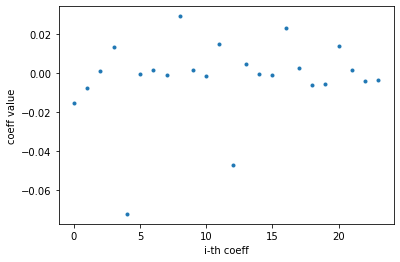

In [10]:
# Building the model

modelName = "linear"
model     = getModel(modelName)
trainedL1 = pipe_RMSE_model( model, modelName, Xcopy, y_train_tr )


RMSE for linear:
  0.04681028625255197


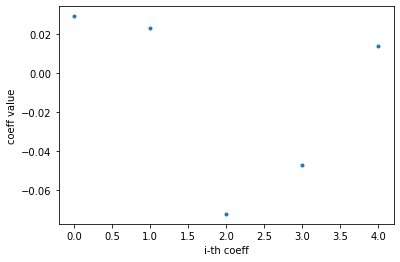

In [11]:
modelName = "linear"
model     = getModel(modelName)
trainedL2 = pipe_RMSE_model( model, modelName, Xcopy, y_train_tr, listColumns=onlyCols )


RMSE for linear:
  0.015201825668111842


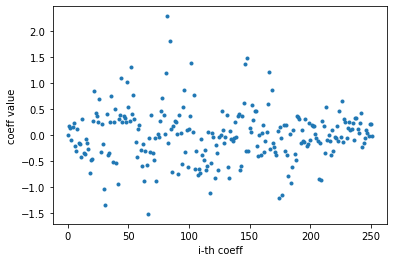

In [12]:
modelName = "linear"
model     = getModel(modelName)
trainedL3 = pipe_RMSE_model( model, modelName, Xp_train_tr, y_train_tr )



In [13]:
modelName = "randomForest"
model     = getModel(modelName)
trainedR1 = pipe_RMSE_model( model, modelName, Xcopy, y_train_tr )


RMSE for randomForest:
  0.006534228906674215


In [14]:
modelName = "randomForest"
model     = getModel(modelName)
trainedR2 = pipe_RMSE_model( model, modelName, Xcopy, y_train_tr, listColumns=onlyCols )


RMSE for randomForest:
  0.006350424079683631


RMSE:  0.02860508194494344


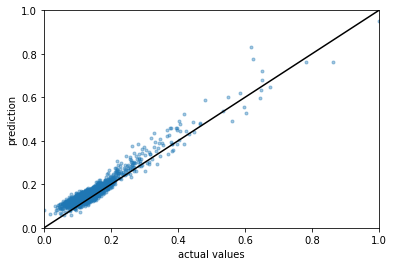

In [15]:
validation( df_test, trainedL3, listColumns=onlyCols, poly=poly )

RMSE:  0.02950875300966513


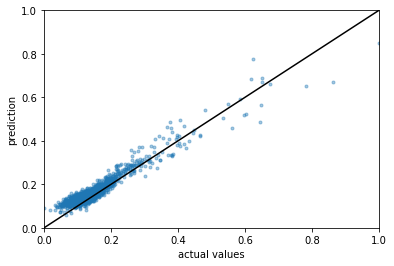

In [16]:
validation( df_test, trainedR2, listColumns=onlyCols, poly=None )


In [ ]:
# How to improve:

# #%%
# from sklearn.model_selection import GridSearchCV
# #
# param_grid = [
#     {'n_estimators': [3, 10, 30, 50, 100], 'max_features': [2, 4, 6, 8]},
#     {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
#   ]

# model = RandomForestRegressor()

# grid_search = GridSearchCV(model, param_grid, cv=5,
#                            scoring='neg_mean_squared_error',
#                            return_train_score=True)

# grid_search.fit( Xcopy[:, onlyCols], y_train_tr )
# #%%
# model = RandomForestRegressor(n_estimators=100, max_features=8)


